In [ ]:
# Importamos la librerias necesarias
import time
import numpy as np
import imageio.v2 as io

import torch
import torch.nn as nn
from torchsummary import summary
import copy

import seaborn as sns

# 1.1)
import os
import pickle
import datetime
from collections import defaultdict
# 1.2)
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import sklearn as skl
import pandas as pd
#import dill
import json
# 1.3)
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose
#from torchviz import make_dot
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

In [ ]:
# 1.4)
import google.colab
from google.colab import files

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Usando el dispositivo {}'.format(device))

Usando el dispositivo cpu


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
    ,transforms.Normalize((0.5,), (0.5,))
])
# Dowload and load the training data
train_set_orig = datasets.FashionMNIST('MNIST_data/', download=True, train=True , transform=transform)
valid_set_orig = datasets.FashionMNIST('MNIST_data/', download=True, train=False, transform=transform)

100%|██████████| 26.4M/26.4M [00:02<00:00, 8.87MB/s]


Extracting MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 136kB/s]


Extracting MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 2.58MB/s]


Extracting MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 13.8MB/s]

Extracting MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



In [ ]:
labels_names = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

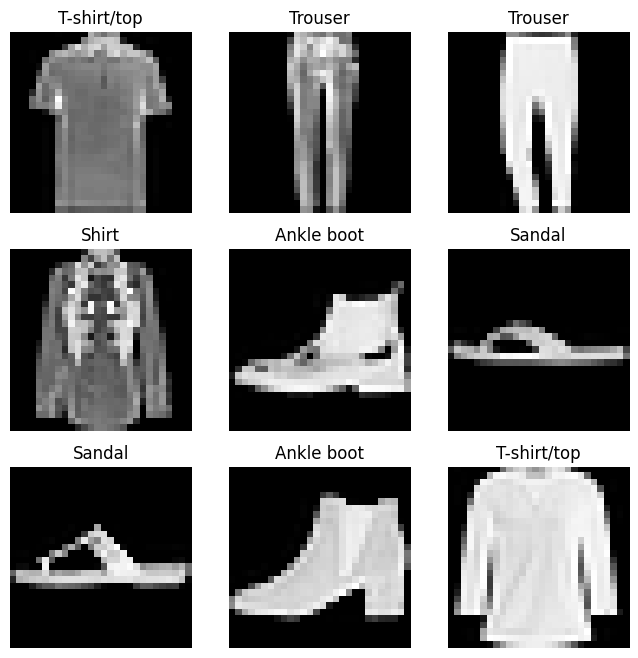

In [ ]:
fig, axes = plt.subplots(3,3, figsize=(8,8))

for i in range(9):
    #eligo una imagen random del train_set
    img, label = train_set_orig[np.random.randint(len(train_set_orig))]
    ax = axes[i // 3, i % 3]
    ax.imshow(img.squeeze(), cmap="Greys_r")
    ax.set_title(labels_names[label])
    ax.axis('off')

plt.show()

In [ ]:
class customDataset(Dataset):
  def __init__(self,dataset):
    self.dataset = dataset
  def __len__(self):
    return len(self.dataset)
  def __getitem__(self,i):
    image, label = self.dataset[i]
    input = image
    output = image
    return input, output

In [ ]:
train_set = customDataset(train_set_orig)
valid_set = customDataset(valid_set_orig)


In [ ]:
def convt2d_z_out(z_in, stride, padding, dilation, kernel_size, output_padding):
  z_out = (z_in-1)*stride - 2*padding + dilation*(kernel_size-1) + output_padding + 1
  return z_out

convt2d_z_out(13,2,1,1,6,0)

28

In [ ]:
z_in = 13
kernel_size = 6
stride = 2
padding = 1
output_padding = 8
dilation = 1
z_out = convt2d_z_out(z_in,kernel_size,stride,padding,output_padding,dilation)
print(z_out)

77


In [ ]:
class Autoencoder(nn.Module):
  def __init__(self,n=64,p=0.2):
    super().__init__()
    self.linear_relu_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28,n),
        nn.ReLU(),
        nn.Dropout(p),
        nn.Linear(n,28*28),
        nn.ReLU(),
        nn.Dropout(p),
        nn.Unflatten(1,(1,28,28))
    )
  def forward(self,x):
    return self.linear_relu_stack(x)

In [ ]:
class Autoencoder_Conv(nn.Module):
  def __init__(self,n=28*28, p=0.2):
    super().__init__()
    self.n = n
    self.p = p
    #Enconder
    self.encoder = nn.Sequential(
      # conv1
        nn.Conv2d(1, 16, kernel_size=3, padding=0), # (1, 28, 28) -> (16, 26, 26)
        # self no se que
        nn.ReLU(),
        nn.Dropout(self.p),
        nn.MaxPool2d(2,2), # (16, 26, 26) -> (16, 13, 13)
      # conv2
        nn.Conv2d(16, 32, kernel_size=3), #(16, 13, 13) -> (32, 11, 11)
        #self no se que
        nn.ReLU(),
        nn.Dropout(self.p),
        nn.MaxPool2d(2,2), # (32, 11, 11) -> (32, 5, 5)
      # linear enconder
        nn.Flatten(), # (32, 5, 5) -> (32*5*5)
        nn.Linear(32*5*5, self.n), # (32*5*5,) -> (n,) NO SE QUE DICE
        nn.ReLU(),
        nn.Dropout(self.p),
    )
    # Decoder
    self.decoder = nn.Sequential(
        # linear decoder
        nn.Linear(self.n, 32*5*5),# (n,) -> (32*5*5)
        nn.ReLU(),
        nn.Dropout(self.p),
        nn.Unflatten(1, (32, 5, 5)), # (32*5*5) -> (32,5,5)
        # conv no se que
        nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2, padding=2, output_padding=0, dilation=2),
        nn.ReLU(),
        nn.Dropout(self.p),
        # conv1 transposer no que se
        nn.ConvTranspose2d(16, 1, kernel_size=6, stride=2, padding=1, output_padding=0, dilation=1),
        # nnsigmoid no se que
        # nn.droput asdasd
     )

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [ ]:
class Autoencoder_SinLineal(nn.Module):
        def __init__(self,n=28*28, p=0.2):
            super().__init__()
            self.n = n
            self.p = p
            #Enconder
            self.encoder = nn.Sequential(
            # conv1
                nn.Conv2d(1, 16, kernel_size=3, padding=0), # (1, 28, 28) -> (16, 26, 26)
                # self no se que
                nn.ReLU(),
                nn.Dropout(self.p),
                nn.MaxPool2d(2,2), # (16, 26, 26) -> (16, 13, 13)
            # conv2
                nn.Conv2d(16, 32, kernel_size=3), #(16, 13, 13) -> (32, 11, 11)
                #self no se que
                nn.ReLU(),
                nn.Dropout(self.p),
                nn.MaxPool2d(2,2), # (32, 11, 11) -> (32, 5, 5)
            # linear enconder
                # nn.Flatten(), # (32, 5, 5) -> (32*5*5)
                # nn.Linear(32*5*5, self.n), # (32*5*5,) -> (n,) NO SE QUE DICE
                # nn.ReLU(),
                # nn.Dropout(self.p),
            )
            # Decoder
            self.decoder = nn.Sequential(
                # linear decoder
                # nn.Linear(self.n, 32*5*5),# (n,) -> (32*5*5)
                # nn.ReLU(),
                # nn.Dropout(self.p),
                # nn.Unflatten(1, (32, 5, 5)), # (32*5*5) -> (32,5,5)
                # conv no se que
                nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2, padding=2, output_padding=0, dilation=2),
                nn.ReLU(),
                nn.Dropout(self.p),
                # conv1 transposer no que se
                nn.ConvTranspose2d(16, 1, kernel_size=6, stride=2, padding=1, output_padding=0, dilation=1),
                # nnsigmoid no se que
                # nn.droput asdasd
            )

        def forward(self, x):
            x = self.encoder(x)
            x = self.decoder(x)
            return x

    #medio feo este bloque


In [ ]:

p = 0.2
autoencoder = Autoencoder(p=p)
autoencoder_convVVV = Autoencoder_Conv(p=p)
#autoencoder_conv = Autoencoder_SinLineal(p=p)
model = autoencoder_convVVV

In [ ]:
autoencoder_convVVV.encoder

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (5): ReLU()
  (6): Dropout(p=0.2, inplace=False)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=800, out_features=784, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.2, inplace=False)
)

In [ ]:
autoencoder_conv2 = Autoencoder_Conv(p=0.0001)
autoencoder_conv2.encoder

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Dropout(p=0.0001, inplace=False)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (5): ReLU()
  (6): Dropout(p=0.0001, inplace=False)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=800, out_features=784, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.0001, inplace=False)
)

In [ ]:
def batch(x):
  return x.unsqueeze(0)

def unbatch(x):
  return x.squeeze().detach().cpu().numpy()

In [ ]:
image,_ = train_set[1]
pred = model(batch(image))
print(image.size())
print(unbatch(image).shape)
print(pred.size())
print(unbatch(pred).shape)

torch.Size([1, 28, 28])
(28, 28)
torch.Size([1, 1, 28, 28])
(28, 28)


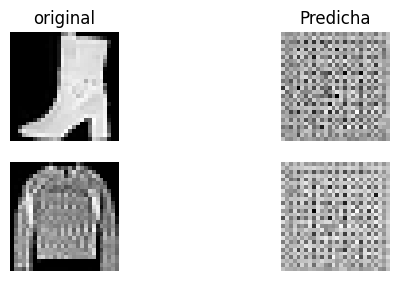

In [ ]:
figure = plt.figure()
rows,col = 3,2
i = 0
for row in (1,rows+1):
  j = torch.randint(len(train_set),size=(1,)).item()
  i += 1
  image,_ = train_set[j]
  figure.add_subplot(rows,col,i)
  if row == 1:
    plt.title("original")
  plt.axis("off")
  plt.imshow(unbatch(image),cmap="Greys_r")
  i += 1
  figure.add_subplot(rows,col,i)
  if row == 1:
    plt.title("Predicha")
  plt.axis("off")
  img_pred =unbatch(model(batch(image)))
  plt.imshow(img_pred,cmap="Greys_r")
plt.show()

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer, verbose=False):
    # activamos la maquinaria de enretmiento
    model.train()
    # definimos unas constantes
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_batch_avrg_loss    = 0
    num_proccessed_samples = 0
    # hacemos el modelo a pa gpu
    model = model.to(device)

    # iteramos sobre los lotes
    for batch, (X, y) in enumerate(dataloader):
        # Copiamos las entradas y las salidas al dispositivo de trabajo
        X = X.to(device)
        y = y.to(device)
        batch_size = len(X)
        num_proccessed_samples += batch_size
        #calculamos la predicción del modelo y la correspondiente función perdida
        pred = model(X)
        loss = loss_fn(pred, y)
        # backpropaamos
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # calculamos la pérdida promedio del batch y lo agregamos a la suma correspondiente
        batch_avrg_loss      = loss.item()
        sum_batch_avrg_loss += batch_avrg_loss
        if batch % (num_batches/10) == 0 and verbose:
            print(f"@train_loop btach={batch:>5d} batch_avrg_loss={batch_avrg_loss:>7f} processed-samples={100*num_proccessed_samples/num_samples:>5f}%")
            ...
    avg_loss = sum_batch_avrg_loss/num_batches
    return avg_loss


In [ ]:
def eval_loop(dataloader, model, loss_fn):
    # desactivamos la maquinaria de entrenamiendo del modelo
    model.eval()
    # definimos ciertas constantes
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_batch_avrg_loss     = 0
    num_proccessed_samples  = 0
    # movemos el modelo a la gpu
    model = model.to(device)
    # desactivamos el cálculo de gradientes
    with torch.no_grad():
        for X, y in dataloader:
            # Copiamos las entradas y las salidas al dispositivo de trabajo
            X = X.to(device)
            y = y.to(device)
            batch_size = len(X)
            num_proccessed_samples += batch_size
            #calculamos la predicción del modelo
            pred = model(X)
            loss = loss_fn(pred, y)
            # calculamos la pérdida promedio del batch
            batch_avrg_loss      = loss.item()
            sum_batch_avrg_loss += batch_avrg_loss
    #calculamos l a perdida total y la fracción de clasificaciones correctas, y las imprimimos
    avg_loss = sum_batch_avrg_loss/num_batches

    print(f"@eval_loop avg_loss={avg_loss:>8f}")
    return avg_loss


In [ ]:
batch_size = 100
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)

num_train_batches = len(train_loader)
num_valid_batches = len(valid_loader)
print("num_train_batches =",num_train_batches)
print("num_valid_batches =",num_valid_batches)


num_train_batches = 600
num_valid_batches = 100


In [ ]:
#loss_fn = nn.CrossEntropyLoss() #clasificador
loss_fn = nn.MSELoss() #Encoder

In [ ]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)

In [ ]:
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device =", device)
model = model.to(device)

device = cpu


In [ ]:
num_epochs = 30
list_avg_train_loss_wrong = []
list_avg_train_loss = []
list_avg_valid_loss = []

for epoch in range(num_epochs):
  print(f"Epoch {epoch+1}\n-------------------------------")
  avg_train_loss_wrong = train_loop(train_loader, model, loss_fn, optimizer)
  avg_train_loss = eval_loop(train_loader, model, loss_fn)
  avg_valid_loss = eval_loop(valid_loader, model, loss_fn)
  list_avg_train_loss_wrong.append(avg_train_loss_wrong)
  list_avg_train_loss.append(avg_train_loss)
  list_avg_valid_loss.append(avg_valid_loss)
  print(f"avg_train_loss_wrong={avg_train_loss_wrong}")
  print(f"avg_train_loss={avg_train_loss:>7f}")
  print(f"avg_valid_loss={avg_valid_loss:>7f}")
print("Done!")


Epoch 1
-------------------------------
@eval_loop avg_loss=0.154616
@eval_loop avg_loss=0.154494
avg_train_loss_wrong=0.17580268083761136
avg_train_loss=0.154616
avg_valid_loss=0.154494
Epoch 2
-------------------------------
@eval_loop avg_loss=0.124323
@eval_loop avg_loss=0.124491
avg_train_loss_wrong=0.11338942397385836
avg_train_loss=0.124323
avg_valid_loss=0.124491
Epoch 3
-------------------------------
@eval_loop avg_loss=0.119829
@eval_loop avg_loss=0.119970
avg_train_loss_wrong=0.10586948778480292
avg_train_loss=0.119829
avg_valid_loss=0.119970
Epoch 4
-------------------------------
@eval_loop avg_loss=0.106063
@eval_loop avg_loss=0.106319
avg_train_loss_wrong=0.10196125987917184
avg_train_loss=0.106063
avg_valid_loss=0.106319
Epoch 5
-------------------------------
@eval_loop avg_loss=0.105268
@eval_loop avg_loss=0.105461
avg_train_loss_wrong=0.09849351475636164
avg_train_loss=0.105268
avg_valid_loss=0.105461
Epoch 6
-------------------------------
@eval_loop avg_loss=0.094

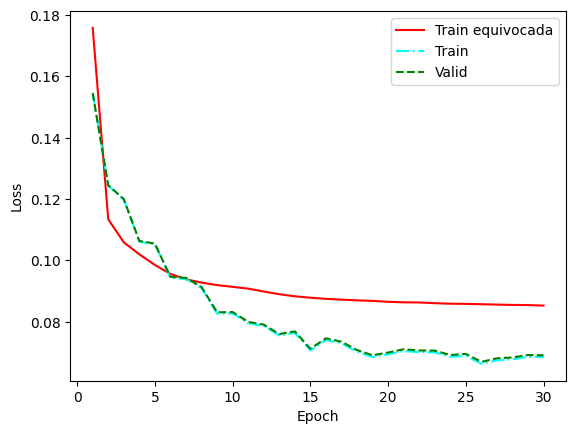

In [ ]:
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(list(range(1,len(list_avg_train_loss_wrong)+1)),list_avg_train_loss_wrong,label="Train equivocada",linestyle="-",c="red")
plt.plot(list(range(1,len(list_avg_train_loss)+1)),list_avg_train_loss,label="Train",linestyle="-.",c="cyan")
plt.plot(list(range(1,len(list_avg_valid_loss)+1)),list_avg_valid_loss,label="Valid",linestyle="--",c="green")
plt.title('')
plt.legend()

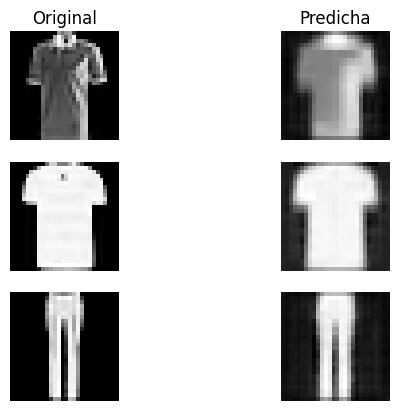

In [ ]:
figure = plt.figure()
rows,col = 3,2
i = 0
model.eval()
for row in range(1,rows+1):
  j = torch.randint(len(train_set),size=(1,)).item()
  i += 1
  image,flatten_image = train_set[j]
  figure.add_subplot(rows,col,i)
  if row==1:
    plt.title("Original")
  plt.axis("off")
  plt.imshow(unbatch(image),cmap="Greys_r")

  i += 1
  figure.add_subplot(rows,col,i)
  if row==1:
    plt.title("Predicha")
  plt.axis("off")

  pred= unbatch(model(batch(image)))
  plt.imshow(pred,cmap="Greys_r")
plt.show()

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer, verbose=False):
    # activamos la maquinaria de enretmiento
    model.train()
    # definimos unas constantes
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_batch_avrg_loss    = 0
    sum_correct            = 0
    num_proccessed_samples = 0
    # hacemos el modelo a pa gpu
    model = model.to(device)

    # iteramos sobre los lotes
    for batch, (X, y) in enumerate(dataloader):
        # Copiamos las entradas y las salidas al dispositivo de trabajo
        X = X.to(device)
        y = y.to(device)
        batch_size = len(X)
        num_proccessed_samples += batch_size
        #calculamos la predicción del modelo y la correspondiente función perdida
        pred = model(X)
        loss = loss_fn(pred, y)
        # backpropaamos
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # calculamos la pérdida promedio del batch y lo agregamos a la suma correspondiente
        batch_avrg_loss      = loss.item()
        sum_batch_avrg_loss += batch_avrg_loss

                # también calculaos el número de preddicciones correctas en el batch y lo agregamos a una suma correspondiente
        sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item() #calculo de precision
        if batch % (num_batches/10) == 0 and verbose:
            print(f"@train_loop btach={batch:>5d} batch_avrg_loss={batch_avrg_loss:>7f} processed-samples={100*num_proccessed_samples/num_samples:>5f}%")
            ...
    avg_loss = sum_batch_avrg_loss/num_batches
    precision = sum_correct/num_samples
    return avg_loss, precision

In [ ]:
def eval_loop(dataloader, model, loss_fn, verbose=False):
    # desactivamos la maquinaria de entrenamiendo del modelo
    model.eval()
    # definimos ciertas constantes
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_batch_avrg_loss     = 0
    sum_correct             = 0
    num_proccessed_samples  = 0
    # movemos el modelo a la gpu
    model = model.to(device)
    # desactivamos el cálculo de gradientes
    with torch.no_grad():
        for X, y in dataloader:
            # Copiamos las entradas y las salidas al dispositivo de trabajo
            X = X.to(device)
            y = y.to(device)
            batch_size = len(X)
            num_proccessed_samples += batch_size
            #calculamos la predicción del modelo
            pred = model(X)
            loss = loss_fn(pred, y)
            # calculamos la pérdida promedio del batch
            batch_avrg_loss      = loss.item()
            # también calculaos el número de preddicciones correctas en el batch y lo sumams al total
            sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            # calculamos el numero de ejemplos procesados
            sum_batch_avrg_loss += batch_avrg_loss
    #calculamos l a perdida total y la fracción de clasificaciones correctas, y las imprimimos
    avg_loss = sum_batch_avrg_loss/num_batches
    precision = sum_correct/num_samples
    print(f"@eval_loop precision={(100*precision):>0.1f}% avg_loss{avg_loss:>8f}")
    return avg_loss,precision

In [ ]:
class Classifier_Conv(nn.Module):
    def __init__(self, autoencoder_conv=None, copy_encoder=True, n=28*28, p=0.2):
        super().__init__()
        if autoencoder_conv is None:
            print("Creating encoder...")
            self.n = n
            self.p = p
            self.lei = 5
            self.ldo = 5
            # self.encoder = nn.Sequential(
            # # conv1
            #     nn.Conv2d(1, 16, kernel_size=3, padding=1), # (1, 28, 28) -> (16, 26, 26)
            #     nn.ReLU(),
            #     nn.Dropout(self.p),
            #     nn.MaxPool2d(2,2), # (16, 26, 26) -> (16, 13, 13)
            # # conv2
            #     nn.Conv2d(16, 32, kernel_size=3, padding=1), #(16, 13, 13) -> (32, 11, 11)
            #     nn.ReLU(),
            #     nn.Dropout(self.p),
            #     nn.MaxPool2d(2,2), # (32, 11, 11) -> (32, 5, 5)
            # # linear enconder
            #     nn.Flatten(), # (32, 5, 5) -> (32*5*5)
            #     nn.Linear(32*self.lei*self.lei, self.n), # (32*5*5,) -> (n,) NO SE QUE DICE
            #     nn.ReLU(),
            #     nn.Dropout(self.p),
            #
            self.encoder = nn.Sequential(
            # conv1
                nn.Conv2d(1, 16, kernel_size=3, padding=0), # (1, 28, 28) -> (16, 26, 26)
                # self no se que
                nn.ReLU(),
                nn.Dropout(self.p),
                nn.MaxPool2d(2,2), # (16, 26, 26) -> (16, 13, 13)
            # conv2
                nn.Conv2d(16, 32, kernel_size=3), #(16, 13, 13) -> (32, 11, 11)
                #self no se que
                nn.ReLU(),
                nn.Dropout(self.p),
                nn.MaxPool2d(2,2), # (32, 11, 11) -> (32, 5, 5)
            # linear enconder
                nn.Flatten(), # (32, 5, 5) -> (32*5*5)
                nn.Linear(32*5*5, self.n), # (32*5*5,) -> (n,) NO SE QUE DICE
                nn.ReLU(),
                nn.Dropout(self.p),
        )
        else:
            self.n = autoencoder_conv.n
            self.p = autoencoder_conv.p
            if copy_encoder:
                print("copianding el encoder...")
                self.encoder = copy.deepcopy(autoencoder_conv.encoder)
            else:
                print("usando el previus encoder...")
                self.encoder = autoencoder_conv.encoder
        # clasificador
        self.clasificador = nn.Sequential(
            nn.Linear(self.n, 10),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.clasificador(x)
        return x

NameError: name 'nn' is not defined

In [ ]:
classifier_conv = Classifier_Conv(autoencoder_conv=autoencoder_convVVV)
clasi_conv = classifier_conv
classifier_conv.encoder

copianding el encoder...


Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (5): ReLU()
  (6): Dropout(p=0.2, inplace=False)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=800, out_features=784, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.2, inplace=False)
)

In [ ]:
image,label = train_set_orig[1]
pred = clasi_conv(batch(image))

In [ ]:
train_loader = DataLoader(train_set_orig, batch_size = batch_size, shuffle=True)
valid_loader = DataLoader(valid_set_orig, batch_size = batch_size, shuffle=True)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device =", device)
model = clasi_conv.to(device)

device = cpu


In [ ]:
learning_rate = 1e-3
#optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False) ##entrenar todo
optimizer = torch.optim.Adam(model.clasificador.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False) ##Solo capa clasificadora

In [ ]:

num_epochs = 30
list_train_avg_loss_wrong = []
list_train_avg_loss = []
list_valid_avg_loss = []
list_train_precision_wrong = []
list_train_precision = []
list_valid_precision = []
for epoch in range(num_epochs):
  print(f"Epoch {epoch+1}\n-------------------------------")
  train_avg_loss_wrong, train_precision_wrong = train_loop(train_loader, model, loss_fn, optimizer)
  train_avg_loss, train_precision = eval_loop(train_loader, model, loss_fn)
  valid_avg_loss, valid_precision = eval_loop(valid_loader, model, loss_fn)
  list_train_avg_loss_wrong.append(train_avg_loss_wrong)
  list_train_avg_loss.append(train_avg_loss)
  list_valid_avg_loss.append(valid_avg_loss)
  list_train_precision_wrong.append(train_precision_wrong)
  list_train_precision.append(train_precision)
  list_valid_precision.append(valid_precision)
  print(f"train_avg_loss_wrong={train_avg_loss_wrong}")
  print(f"train_avg_loss={train_avg_loss:>7f}")
  print(f"valid_avg_loss={valid_avg_loss:>7f}")
  print(f"train_precision_wrong={train_precision_wrong:>7f}")
  print(f"train_precision={train_precision:>7f}")
  print(f"valid_precision={valid_precision:>7f}")
print("Done!")

Epoch 1
-------------------------------
@eval_loop precision=82.3% avg_loss0.757516
@eval_loop precision=81.2% avg_loss0.773122
train_avg_loss_wrong=0.9623241244256496
train_avg_loss=0.757516
valid_avg_loss=0.773122
train_precision_wrong=0.771717
train_precision=0.822950
valid_precision=0.811900
Epoch 2
-------------------------------
@eval_loop precision=84.2% avg_loss0.597879
@eval_loop precision=83.0% avg_loss0.616373
train_avg_loss_wrong=0.5438194978237152
train_avg_loss=0.597879
valid_avg_loss=0.616373
train_precision_wrong=0.827067
train_precision=0.841933
valid_precision=0.829900
Epoch 3
-------------------------------
@eval_loop precision=85.0% avg_loss0.535614
@eval_loop precision=83.6% avg_loss0.556159
train_avg_loss_wrong=0.4774566636482875
train_avg_loss=0.535614
valid_avg_loss=0.556159
train_precision_wrong=0.839567
train_precision=0.850083
valid_precision=0.836200
Epoch 4
-------------------------------
@eval_loop precision=85.6% avg_loss0.498500
@eval_loop precision=84.2

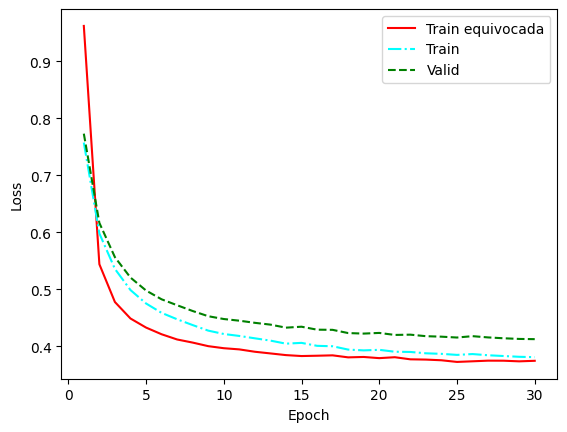

In [ ]:
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.plot(range(1,len(list_train_avg_loss_wrong)+1),list_train_avg_loss_wrong,label="Train equivocada",linestyle="-",c="red")
plt.plot(range(1,len(list_train_avg_loss)+1),list_train_avg_loss,label="Train",linestyle="-.",c="cyan")
plt.plot(range(1,len(list_valid_avg_loss)+1),list_valid_avg_loss,label="Valid",linestyle="--",c="green")
plt.title('')
plt.legend()

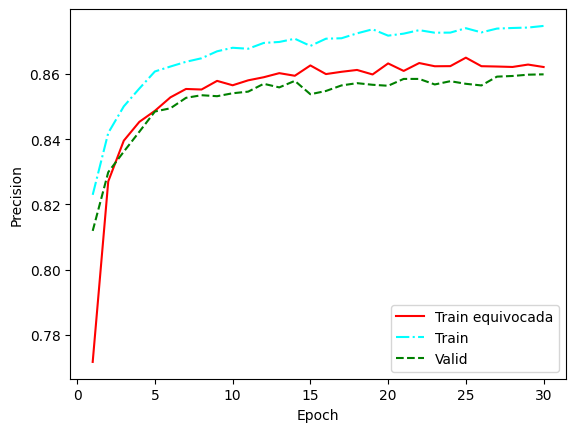

In [ ]:
plt.xlabel("Epoch")
plt.ylabel("Precision")

plt.plot(range(1,len(list_train_precision_wrong)+1),list_train_precision_wrong,label="Train equivocada",linestyle="-",c="red")
plt.plot(range(1,len(list_train_precision)+1),list_train_precision,label="Train",linestyle="-.",c="cyan")
plt.plot(range(1,len(list_valid_precision)+1),list_valid_precision,label="Valid",linestyle="--",c="green")
plt.title('')
plt.legend()

batch=    0 muestras-procesadas:[    0/10000]
batch=   10 muestras-procesadas:[ 1000/10000]
batch=   20 muestras-procesadas:[ 2000/10000]
batch=   30 muestras-procesadas:[ 3000/10000]
batch=   40 muestras-procesadas:[ 4000/10000]
batch=   50 muestras-procesadas:[ 5000/10000]
batch=   60 muestras-procesadas:[ 6000/10000]
batch=   70 muestras-procesadas:[ 7000/10000]
batch=   80 muestras-procesadas:[ 8000/10000]
batch=   90 muestras-procesadas:[ 9000/10000]


<Axes: >

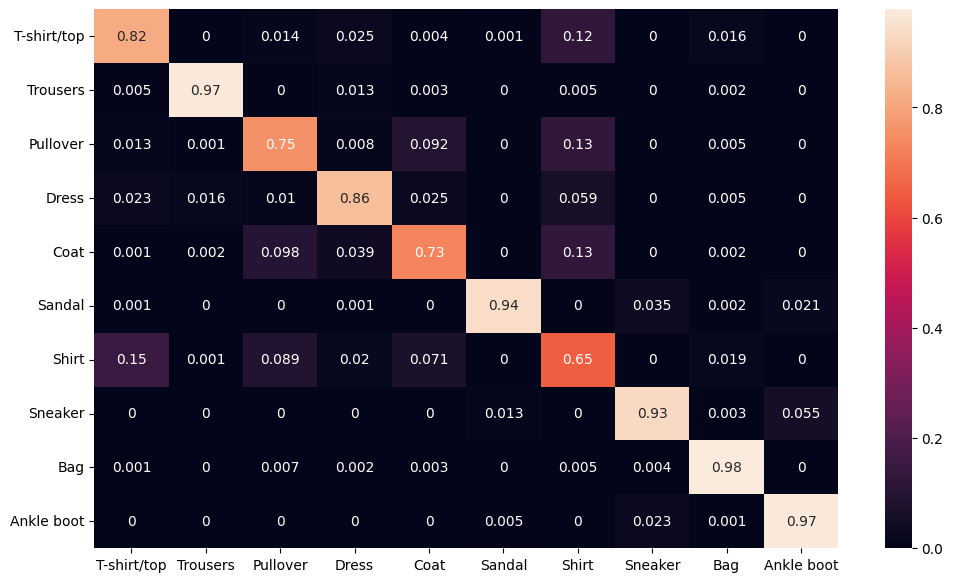

In [ ]:
y_pred = []
y_true = []

size = len(valid_loader.dataset)
for batch,(inputs,labels) in enumerate(valid_loader):
  outputs = model(inputs)
  outputs = (torch.max(torch.exp(outputs),1)[1]).data.cpu().numpy()
  y_pred.extend(outputs)
  labels = labels.data.cpu().numpy()
  y_true.extend(labels)

  if batch % 10 == 0:
    current = batch * len(inputs)
    print(f"batch={batch:>5d} muestras-procesadas:[{current:>5d}/{size:>5d}]")

classes = ('T-shirt/top', 'Trousers', "Pullover",
           'Dress', 'Coat', 'Sandal', 'Shirt',
           'Sneaker', 'Bag', 'Ankle boot')
cf_matrix = confusion_matrix(y_true,y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix,axis=1)[:, None], index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)